In [1]:
import tensorflow as tf
import os
import sys
from importlib import reload
import gdal

sys.path.insert(0, '../src')
import deepgeo.common.filesystem as fs
import deepgeo.common.geofunctions as gf
import deepgeo.common.visualization as vis
import deepgeo.dataset.preprocessor as prep
import deepgeo.dataset.sequential_chips as seqchips
import deepgeo.dataset.utils as dsutils 
import deepgeo.networks.model_builder as mb

reload(dsutils)
reload(gf)
reload(mb)
reload(prep)
reload(seqchips)

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'deepgeo.dataset.sequential_chips' from '../src/deepgeo/dataset/sequential_chips.py'>

In [2]:
network = 'unet'
DATA_DIR = '/home/raian/doutorado/Dados/generated'
trained_model = os.path.join(DATA_DIR, 'tf_logs', 'experiments', network, 'test_unet_29_04_2019-12_51_06/')
raster_path = os.path.join(DATA_DIR, 'stacked_mosaic_2016_2017.tif')
out_pred_dir = os.path.join(trained_model, 'predictions')
output_pred = os.path.join(out_pred_dir, 'prediction_2017.tiff')
fs.mkdir(out_pred_dir)

In [3]:
preproc = prep.Preprocessor(raster_path, no_data=-9999)
preproc.set_nodata_value(-10)
preproc.standardize_image()
raster_array = preproc.get_raster_stacked_raster()

params = {'raster_array': raster_array,
          'overlap': [93, 93],
          'win_size': 286}

chips = seqchips.SequentialChipGenerator(params).generate_chips()

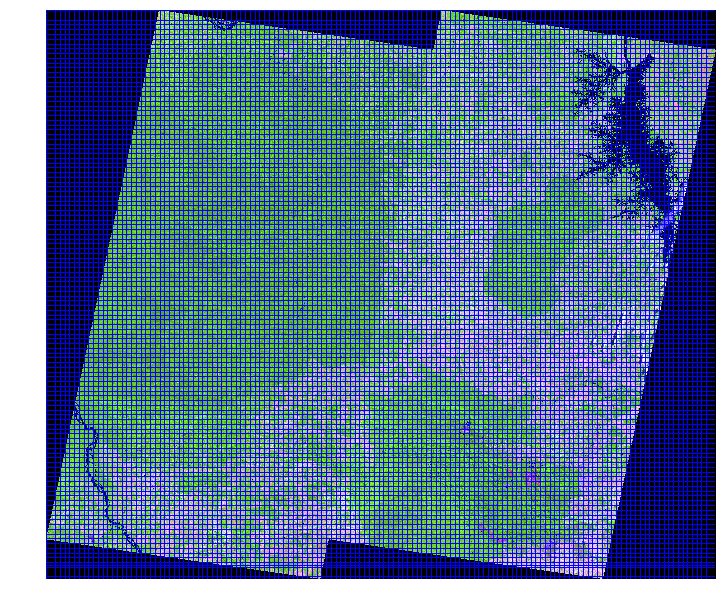

In [4]:
# original_raster = gf.load_image(raster_path, 0)
vis.plot_chips(chips, raster_array, bands=[8, 7, 6], contrast=True)

In [5]:
params = {'batch_size': 40,
          'fusion': 'early',
          'l2_reg_rate': 0.0005,
          'num_classes': 3}
reload(mb)
model = mb.ModelBuilder(network)
predictions = model.predict(chips['chips'], params=params, model_dir=trained_model)
out_pred = chips.copy()
out_pred['chips'] = predictions.copy()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `tf.contrib.distribute.MirroredStrategy` instead.
Classifying image with structure  (4260, 286, 286, 10) ...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use st

In [9]:
reload(gf)
gf.write_chips(output_pred, raster_path, out_pred)

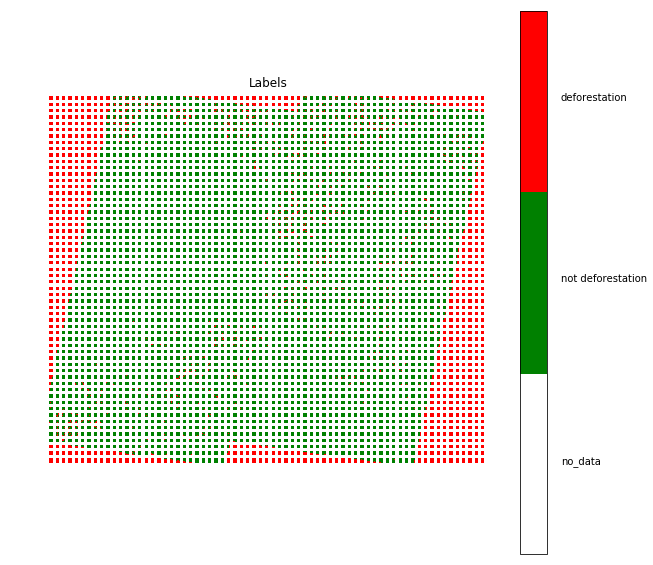

In [11]:
new_ds = gdal.Open(output_pred)
rarr = new_ds.ReadAsArray()
vis.plot_labels(rarr, ['no_data', 'not deforestation', 'deforestation'], colors=['white', 'green', 'red'])